In [1]:
import os
import sys
import operator
from pathlib import Path
from dotenv import load_dotenv
from langchain_core.documents import Document

# 프로젝트 루트를 Python 경로에 추가 (rag 모듈 import를 위해 필요)
project_root = Path().resolve().parent if Path().resolve().name == "LangGraph" else Path().resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"✅ 프로젝트 루트 추가됨: {project_root}")

✅ 프로젝트 루트 추가됨: C:\Users\rkddn\YAI-NLP


In [2]:
from huggingface_hub import login
hf_token = os.getenv("HF_API_KEY")
if hf_token:
    os.environ["HF_API_KEY"] = hf_token
else:
    print("⚠️ 경고: HF_API_KEY이 없습니다.")

login(token=os.getenv("HF_API_KEY"))

In [3]:
from rag.ingest import ingest_documents, ingest_pdfs

ingest_pdfs(
    pdf_paths=["nlp.pdf"],
    persist_directory="./chroma_db",
    collection_name="my_collection",
)
ingest_documents(
    file_paths=["highmath12.txt"],
    persist_directory="./chroma_db",
    collection_name="my_collection",
)

Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats


  📄 nlp.pdf: 7페이지 로드
📄 총 7개 페이지 로드 완료
✂️ 총 30개 청크로 분할 완료
🌐 임베딩: API 방식 (BAAI/bge-m3)
✅ ChromaDB 저장 완료: ./chroma_db (collection: my_collection, 30개 청크)
  📄 highmath12.txt: 1개 문서 로드
📄 총 1개 문서 로드 완료
✂️ 총 16개 청크로 분할 완료
🌐 임베딩: API 방식 (BAAI/bge-m3)
✅ ChromaDB 저장 완료: ./chroma_db (collection: my_collection, 16개 청크)


In [4]:
# LangSmith 추적 설정 (langchain_teddynote 제거 → 환경변수 직접 설정)
load_dotenv()

# LangSmith 추적이 필요한 경우 아래 환경변수를 .env에 설정하거나 직접 활성화
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_PROJECT"] = "LangSmith_YAI"
# os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

True

In [5]:
# ===== 프로토타입(PDF) → 프로덕션(ChromaDB) 전환 =====
# 변수명을 retriever / chain 으로 통일하여 이후 노드 코드 수정 최소화

# ── [프로토타입] PDF 기반 (기존 코드) ────────────────────────
# from rag.pdf import PDFRetrievalChain
# print("🚀 Hugging Face 기반 PDF 체인 생성 시작...")
# _rag = PDFRetrievalChain(["nlp.pdf"]).create_chain()
# print("✅ 체인 생성 완료!")
# retriever = _rag.retriever
# chain = _rag.chain

# ── [프로덕션] ChromaDB 기반 ─────────────────────────────────
from rag.chroma import ChromaRetrievalChain

print("🚀 ChromaDB 기반 체인 생성 시작...")
_rag = ChromaRetrievalChain(
    persist_directory="./chroma_db",       # ChromaDB 저장 경로
    collection_name="my_collection",        # 컬렉션 이름
    k=10,                                   # 검색 문서 수
).create_chain()
print("✅ 체인 생성 완료!")

retriever = _rag.retriever
chain = _rag.chain

🚀 ChromaDB 기반 체인 생성 시작...
🌐 임베딩: API 방식 (BAAI/bge-m3)
📚 ChromaDB 연결 완료: 182개 문서 (collection: my_collection)
✅ 체인 생성 완료!


C:\Users\rkddn\YAI-NLP\rag\chroma.py:66: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  self.vectorstore = Chroma(


In [6]:
# retriever 테스트 (pdf_retriever → retriever 로 통일)
# search_result = retriever.invoke("수학1 핵심 커리큘럼을 설명해주세요요")
# search_result

In [7]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# 에이전트 상태를 정의하는 타입 딕셔너리, 메시지 시퀀스를 관리하고 추가 동작 정의
class AgentState(TypedDict):
    # add_messages reducer 함수를 사용하여 메시지 시퀀스를 관리
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [8]:
from typing import TypedDict, Annotated, List
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    #policy: Annotated[str, "Policy"] #누적됨
    question: Annotated[str, "Question"]
    context: Annotated[str, "Context"]
    answer: Annotated[str, "Answer"]
    messages: Annotated[list, add_messages] #메시지(누적되는 list)
    relevance: Annotated[str, "Relevance"]

    """
    context 구성요소
    1. 챗봇 대화 기록
    2. 웹 검색 결과
    3. 시스템 프롬프트
    4. [POLICY]
    5. 사용자 질문
    6. 최근에 retrieve 한 내용


    context내에서 처리 or retrieve?
    -> 프롬프트 내에 연관성이 있는 맥락이 있는지 서치하는 LLM 모델 필요할 듯
    """
    

<h3>노드 정의</h3>

Relevance 체크용 모델

In [9]:
#일단 Relevance용 모델 정의
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

hf_llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.1-8B-Instruct",
    task="text-generation",
    temperature=0.0,
    max_new_tokens=512,
)

chat_hf = ChatHuggingFace(llm=hf_llm)

In [ ]:
import json
import re
from rag.utils import format_docs

# ※ langchain_teddynote.evaluator.GroundednessChecker 제거
# ※ langchain_teddynote.messages.messages_to_history 제거

def retrieve_or_not(state: GraphState) -> str:
    """
    사용자 질문에 대해 문서 검색(retrieve)이 필요한지 판단.
    - 검색 불필요 → "not retrieve" → llm_answer로 직행
    - 검색 필요 → "retrieve" → retrieve 노드로 이동
    Hugging Face Meta Llama(chat_hf) 사용.
    """
    question = state["question"]
    if not question:
        return "not retrieve"

    prompt = f"""
                다음 사용자 질문에 답하려면 **문서/벡터DB 검색(retrieve)**이 필요한지 판단하세요.

                판단 기준:
                - 인사, 감정, 단순 대화("안녕", "고마워", "뭐해" 등), 잡담 → 검색 불필요
                - 문서에 있을 법한 전문 지식 질문 → 검색 필요
                - 최신 정보/뉴스(노벨상, 날짜별 사건 등) → 검색 필요

                질문: {question}

                *반드시 아래 JSON 형식으로만 답하세요. 다른 텍스트 없이 JSON만 출력.
                {{"need_retrieve": "yes"}} 또는 {{"need_retrieve": "no"}}
                """

    try:
        response = chat_hf.invoke(prompt)
        text = (response.content or "").strip()
        match = re.search(r"\{[^{}]*\"need_retrieve\"[^{}]*\}", text)
        if match:
            data = json.loads(match.group(0))
            need = (data.get("need_retrieve") or "no").lower()
            if need in ("yes", "true", "1"):
                print("==============retrieve Node============")
                return "retrieve"
        print("==============go to llm_answer============")
        return "not retrieve"
    except Exception:
        return "retrieve"


def upload_to_vectorDB(state: GraphState) -> bool:
    if "Search 함수에서 찾은 내용을 -> 벡터DB에 업로드 성공":
        return True
    else:
        return False

def multiturn_chat_to_vectorDB(state: GraphState) -> bool:
    if "컨텍스트가 너무 길어져서 -> 벡터DB에 업로드 성공":
        return True
    else:
        return False
    
"""===========노드 정의==========="""


def retrieve(state: GraphState) -> GraphState:
    """ChromaDB (또는 PDF) retriever로 문서 검색"""
    latest_question = state["question"]
    retrieved_docs = retriever.invoke(latest_question)  # pdf_retriever → retriever
    formatted_docs = format_docs(retrieved_docs)
    return GraphState(context=formatted_docs)

def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    chat_history = state.get("messages", [])
    
    try:
        response = chain.invoke(  # pdf_chain → chain
            {
                "question": latest_question,
                "context": context,
                "chat_history": chat_history,
            }
        )
    except Exception as e:
        # BadRequestError 등 상세한 에러 정보 출력
        print("=" * 80)
        print("❌ LLM 호출 중 에러 발생!")
        print("=" * 80)
        print(f"에러 타입: {type(e).__name__}")
        print(f"에러 메시지: {str(e)}")
        
        if hasattr(e, 'response'):
            resp = e.response
            print(f"\nAPI 응답 객체: {resp}")
            try:
                if hasattr(resp, 'text'):
                    print(f"API 응답 본문 (text): {resp.text}")
                elif hasattr(resp, 'content'):
                    print(f"API 응답 본문 (content): {resp.content}")
                if hasattr(resp, 'json'):
                    try:
                        error_json = resp.json()
                        print(f"API 응답 본문 (JSON): {json.dumps(error_json, indent=2, ensure_ascii=False)}")
                    except:
                        pass
            except Exception as resp_e:
                print(f"응답 본문 읽기 실패: {resp_e}")
        
        if hasattr(e, 'status_code'):
            print(f"HTTP 상태 코드: {e.status_code}")
        if hasattr(e, 'request_id'):
            print(f"Request ID: {e.request_id}")
        
        context_str = str(context)
        print("\n입력 데이터 정보:")
        print(f"  - question 길이: {len(latest_question)} 문자")
        print(f"  - context 길이: {len(context_str)} 문자")
        estimated_tokens = len(context_str) // 2
        print(f"  - context 추정 토큰 수: 약 {estimated_tokens:,} 토큰")
        print(f"  - chat_history 타입: {type(chat_history)}, 길이: {len(chat_history) if isinstance(chat_history, list) else 'N/A'}")
        print(f"\n  - context 미리보기 (처음 200자): {context_str[:200]}...")
        print("=" * 80)
        raise
    
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )

Relevance Check Node (question-retrieve)

In [11]:
import json
import re

def relevance_check(state: GraphState) -> GraphState:
    prompt = f"""
You are a grader assessing whether a retrieved document is relevant to the given question.
Return ONLY valid JSON like: {{"score": "yes"}} or {{"score": "no"}}.

Question:
{state["question"]}

Retrieved document:
{state["context"]}
""".strip()

    # HF 모델 호출
    response = chat_hf.invoke(prompt)

    # ChatHuggingFace는 보통 response.content에 텍스트가 들어있음
    text = response.content.strip()

    # JSON만 추출 (모델이 앞뒤에 텍스트를 섞는 경우 대비)
    match = re.search(r"\{.*\}", text, re.DOTALL)
    if match:
        text = match.group(0)

    try:
        data = json.loads(text)
        score = data.get("score", "no").lower()
    except Exception:
        score = "no"

    if score not in ["yes", "no"]:
        score = "no"

    print("==== [RELEVANCE CHECK] ====")
    print(score)

    return {"relevance": score}

def is_relevant(state: GraphState) -> str:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

Web Search Node & Summarization

In [12]:
# ※ langchain_teddynote.tools.tavily.TavilySearch 제거
#   → langchain_community.tools.tavily_search.TavilySearchResults 사용

from langchain_community.tools.tavily_search import TavilySearchResults

MAX_TOKENS_PER_DOC = 1000
CHARS_PER_TOKEN_EST = 1.5
MAX_CHARS_PER_DOC = int(MAX_TOKENS_PER_DOC * CHARS_PER_TOKEN_EST)  # 약 1500자


def _summarize_if_long(content: str, llm, max_chars: int = MAX_CHARS_PER_DOC) -> str:
    """텍스트가 max_chars를 초과하면 LLM으로 요약."""
    if len(content) <= max_chars:
        return content
    prompt = (
        f"아래 텍스트를 핵심만 남겨 {max_chars}자 이내로 요약해주세요. "
        f"요약은 한글로 작성하고, 불필요한 반복은 제거하세요. 요약만 출력하세요.\n\n"
        f"---\n{content[:8000]}\n---"
    )
    try:
        response = llm.invoke(prompt)
        text = (response.content if hasattr(response, "content") else str(response)).strip()
        return text[:max_chars]
    except Exception:
        return content[:max_chars] + "..."


def web_search(state: GraphState) -> GraphState:
    """
    웹 검색 노드
    langchain_community의 TavilySearchResults 사용 (langchain_teddynote 의존 제거)
    """
    tavily_tool = TavilySearchResults(
        max_results=5,
        search_depth="basic",
    )

    search_query = state["question"]
    search_results = tavily_tool.invoke(search_query)
    # search_results: List[dict] → 각 dict에 'url', 'content' 키 존재

    # 검색 결과를 context 문자열로 포맷팅
    context_parts = []
    for result in search_results:
        url = result.get("url", "")
        content = result.get("content", "")

        # 긴 결과는 요약
        content = _summarize_if_long(content, chat_hf)
        context_parts.append(f"{content}\n출처: {url}")

    formatted_context = "\n\n---\n\n".join(context_parts)

    return GraphState(context=formatted_context)


<h3>그래프 생성</h3>

In [13]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("web_search", web_search)

workflow.add_conditional_edges(
    START,
    retrieve_or_not,
    {
        "retrieve": "retrieve",
        "not retrieve": "llm_answer",
    },
)

workflow.add_edge("retrieve", "relevance_check")

workflow.add_conditional_edges(
    "relevance_check",
    is_relevant,
    {
        "relevant": "llm_answer",
        "not relevant": "web_search",
    },
)

workflow.add_edge("web_search", "llm_answer")
workflow.add_edge("llm_answer", END)
workflow.set_entry_point("retrieve")
memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

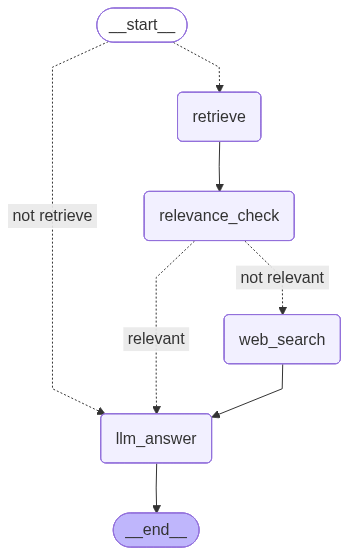

In [14]:
# ※ langchain_teddynote.graphs.visualize_graph 제거 → 자체 구현 사용
from rag.graph_utils import visualize_graph

visualize_graph(app)

<h3>그래프 실행</h3>

In [21]:
# ※ langchain_teddynote.messages 제거 → rag.graph_utils 사용
from langchain_core.runnables import RunnableConfig
from rag.graph_utils import invoke_graph, random_uuid

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

inputs = GraphState(question="수학1 교육과정의 핵심 내용에 대해서 설명해줘")

invoke_graph(app, inputs, config)

==============retrieve Node============

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
  고등학교 교육과정의 핵심 축을 담당하는 **수학 I**과 **수학 II**는 수능 수학의 공통 과목이자, 이후 미적분이나 기하, 확률과 통계로 나아가는 필수적인 기초입니다. 요청하신 대로 텍스트로만 구성하여 각 과목의 핵심 개념과 주요 문제 유형을 상세히 정리해 드립니다.

---

### **[수학 I] : 함수와 수열의 해석**

수학 I은 크게 지수·로그함수, 삼각함수, 수열의 세 파트로 나뉩니다. 기존의 대수적 계산을 넘어 '새로운 함수의 그래프 해석'과 '규칙성의 발견'이 핵심입니다. highmath12.txt  
 고등학교 교육과정의 핵심 축을 담당하는 **수학 I**과 **수학 II**는 수능 수학의 공통 과목이자, 이후 미적분이나 기하, 확률과 통계로 나아가는 필수적인 기초입니다. 요청하신 대로 텍스트로만 구성하여 각 과목의 핵심 개념과 주요 문제 유형을 상세히 정리해 드립니다.

---

### **[수학 I] : 함수와 수열의 해석**

수학 I은 크게 지수·로그...
==== [RELEVANCE CHECK] ====
yes

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
 yes

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
 수학 I 교육과정의 핵심 내용은 다음과 같습니다.

1.  **지수·로그함수:** 지수함수와 로그함수의 개념, 그래프, 성질을 학습합니다. 지수함수의 성질을 이용하여 수열의 규칙을 발견하고, 로그함수를 이용하여 수식의 변형을 해석합니다.
2.  **삼각함수:** 삼각함수의 개념, 그래프, 성질을 학

{'question': '수학1 교육과정의 핵심 내용에 대해서 설명해줘',
 'context': " 고등학교 교육과정의 핵심 축을 담당하는 **수학 I**과 **수학 II**는 수능 수학의 공통 과목이자, 이후 미적분이나 기하, 확률과 통계로 나아가는 필수적인 기초입니다. 요청하신 대로 텍스트로만 구성하여 각 과목의 핵심 개념과 주요 문제 유형을 상세히 정리해 드립니다.\n\n---\n\n### **[수학 I] : 함수와 수열의 해석**\n\n수학 I은 크게 지수·로그함수, 삼각함수, 수열의 세 파트로 나뉩니다. 기존의 대수적 계산을 넘어 '새로운 함수의 그래프 해석'과 '규칙성의 발견'이 핵심입니다. highmath12.txt  \n 고등학교 교육과정의 핵심 축을 담당하는 **수학 I**과 **수학 II**는 수능 수학의 공통 과목이자, 이후 미적분이나 기하, 확률과 통계로 나아가는 필수적인 기초입니다. 요청하신 대로 텍스트로만 구성하여 각 과목의 핵심 개념과 주요 문제 유형을 상세히 정리해 드립니다.\n\n---\n\n### **[수학 I] : 함수와 수열의 해석**\n\n수학 I은 크게 지수·로그함수, 삼각함수, 수열의 세 파트로 나뉩니다. 기존의 대수적 계산을 넘어 '새로운 함수의 그래프 해석'과 '규칙성의 발견'이 핵심입니다. highmath12.txt  \n * **주요 문제 유형:**\n* **그래프 추론 (고난도):** 주어진 조건(극값, 절댓값, 만나는 점의 개수 등)을 만족하는 3차, 4차 함수의 개형을 찾아 식을 완성하는 문제. 수능 수학의 핵심 변별력 파트입니다.\n* **속도와 가속도:** 위치 함수를 미분하여 속도와 가속도를 구하고 운동 방향을 해석하는 문제.\n\n\n\n#### **3. 적분** highmath12.txt  \n * **주요 문제 유형:**\n* **그래프 추론 (고난도):** 주어진 조건(극값, 절댓값, 만나는 점의 개수 등)을 만족하는 3차, 4차 함수의 개형을 찾아 식을 완성하는 문제. 수능 수학의 핵심 변별력

In [16]:
# ※ langchain_teddynote.messages 제거 → rag.graph_utils 사용
from rag.graph_utils import stream_graph

stream_graph(app, inputs, config)

==============retrieve Node============

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
  고등학교 교육과정의 핵심 축을 담당하는 **수학 I**과 **수학 II**는 수능 수학의 공통 과목이자, 이후 미적분이나 기하, 확률과 통계로 나아가는 필수적인 기초입니다. 요청하신 대로 텍스트로만 구성하여 각 과목의 핵심 개념과 주요 문제 유형을 상세히 정리해 드립니다.

---

### **[수학 I] : 함수와 수열의 해석**

수학 I은 크게 지수·로그함수, 삼각함수, 수열의 세 파트로 나뉩니다. 기존의 대수적 계산을 넘어 '새로운 함수의 그래프 해석'과 '규칙성의 발견'이 핵심입니다. highmath12.txt  
 고등학교 교육과정의 핵심 축을 담당하는 **수학 I**과 **수학 II**는 수능 수학의 공통 과목이자, 이후 미적분이나 기하, 확률과 통계로 나아가는 필수적인 기초입니다. 요청하신 대로 텍스트로만 구성하여 각 과목의 핵심 개념과 주요 문제 유형을 상세히 정리해 드립니다.

---

### **[수학 I] : 함수와 수열의 해석**

수학 I은 크게 지수·로그...
==== [RELEVANCE CHECK] ====
yes

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
 yes

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
 수학 I의 핵심 내용은 다음과 같습니다.

* **지수·로그함수:** 지수함수와 로그함수의 개념, 그래프 해석, 그리고 지수함수의 성질(지수함수의 성질, 지수함수의 역함수 등)을 공부합니다.
* **삼각함수:** 삼각함수의 개념, 그래프 해석, 그리고 삼각함수의 성질(삼각함수의 역함수, 삼각함수의 

{'question': '수학1 교육과정의 핵심 내용에 대해서 설명해줘',
 'context': " 고등학교 교육과정의 핵심 축을 담당하는 **수학 I**과 **수학 II**는 수능 수학의 공통 과목이자, 이후 미적분이나 기하, 확률과 통계로 나아가는 필수적인 기초입니다. 요청하신 대로 텍스트로만 구성하여 각 과목의 핵심 개념과 주요 문제 유형을 상세히 정리해 드립니다.\n\n---\n\n### **[수학 I] : 함수와 수열의 해석**\n\n수학 I은 크게 지수·로그함수, 삼각함수, 수열의 세 파트로 나뉩니다. 기존의 대수적 계산을 넘어 '새로운 함수의 그래프 해석'과 '규칙성의 발견'이 핵심입니다. highmath12.txt  \n 고등학교 교육과정의 핵심 축을 담당하는 **수학 I**과 **수학 II**는 수능 수학의 공통 과목이자, 이후 미적분이나 기하, 확률과 통계로 나아가는 필수적인 기초입니다. 요청하신 대로 텍스트로만 구성하여 각 과목의 핵심 개념과 주요 문제 유형을 상세히 정리해 드립니다.\n\n---\n\n### **[수학 I] : 함수와 수열의 해석**\n\n수학 I은 크게 지수·로그함수, 삼각함수, 수열의 세 파트로 나뉩니다. 기존의 대수적 계산을 넘어 '새로운 함수의 그래프 해석'과 '규칙성의 발견'이 핵심입니다. highmath12.txt  \n * **주요 문제 유형:**\n* **그래프 추론 (고난도):** 주어진 조건(극값, 절댓값, 만나는 점의 개수 등)을 만족하는 3차, 4차 함수의 개형을 찾아 식을 완성하는 문제. 수능 수학의 핵심 변별력 파트입니다.\n* **속도와 가속도:** 위치 함수를 미분하여 속도와 가속도를 구하고 운동 방향을 해석하는 문제.\n\n\n\n#### **3. 적분** highmath12.txt  \n * **주요 문제 유형:**\n* **그래프 추론 (고난도):** 주어진 조건(극값, 절댓값, 만나는 점의 개수 등)을 만족하는 3차, 4차 함수의 개형을 찾아 식을 완성하는 문제. 수능 수학의 핵심 변별력

In [17]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 수학1 교육과정의 핵심 내용에 대해서 설명해줘
Answer:
수학 I의 핵심 내용은 다음과 같습니다.

* **지수·로그함수:** 지수함수와 로그함수의 개념, 그래프 해석, 그리고 지수함수의 성질(지수함수의 성질, 지수함수의 역함수 등)을 공부합니다.
* **삼각함수:** 삼각함수의 개념, 그래프 해석, 그리고 삼각함수의 성질(삼각함수의 역함수, 삼각함수의 성질 등)을 공부합니다.
* **수열:** 수열의 개념, 그래프 해석, 그리고 수열의 성질(수열의 규칙, 수열의 합 등)을 공부합니다.

또한, 수학 I의 주요 문제 유형은 다음과 같습니다.

* **그래프 추론:** 주어진 조건(극값, 절댓값, 만나는 점의 개수 등)을 만족하는 3차, 4차 함수의 개형을 찾아 식을 완성하는 문제.
* **속도와 가속도:** 위치 함수를 미분하여 속도와 가속도를 구하고 운동 방향을 해석하는 문제.
